# TFM
# Modelo Sarima

Realizado por: Luis Rendón  <br>
Fecha: DIC/2022

### Importación de librerias necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para manejo de fechas
from datetime import datetime

# Para modelos SARIMAX
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

# Para métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error





### Cargar el Dataset

In [2]:
# Specify the path to your Excel file
file_path = "https://github.com/huambra/Predicting-Shrimp-Exports/raw/refs/heads/main/Exports%20por%20Mercado.xlsx"

# Read the Excel file
df = pd.read_excel(file_path, sheet_name="Unpivot")

# Display the first few rows of the dataframe
print(df.head())

        Date  China   USA    UE
0 2012-12-01     19   291    75
1 2013-01-01    740  4119  4241
2 2013-02-01    380  5844  5407
3 2013-03-01    459  6929  7510
4 2013-04-01    403  7266  7830


In [3]:
df

,Date,China,USA,UE
0,2012-12-01,19,291,75
1,2013-01-01,740,4119,4241
2,2013-02-01,380,5844,5407
3,2013-03-01,459,6929,7510
4,2013-04-01,403,7266,7830
...,...,...,...,...
136,2024-04-01,61599,18589,17849
137,2024-05-01,68663,24101,18514
138,2024-06-01,60804,14983,17458
139,2024-07-01,49431,15963,20369


### Caracteristicas del Dataset (EDA)

In [4]:
# Mostrar información general del dataset
print("Información del dataset:")
print(df.info())

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    141 non-null    datetime64[ns]
 1   China   141 non-null    int64         
 2   USA     141 non-null    int64         
 3   UE      141 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 4.5 KB
None


El dataset cuenta con 141 entradas y 4 columnas, de las cuales la columna `Date` tiene un valor nulo que sería importante gestionar según el análisis requerido. Las columnas tienen tipos de datos adecuados para análisis: `Date` como `datetime64[ns]` para análisis temporales, y `China`, `USA`, y `UE` como `int64` para representar datos numéricos. Los nombres de las columnas son claros, pero podrían estandarizarse para facilitar el manejo automatizado del dataset. Además, es crucial verificar la consistencia de las filas para identificar posibles valores atípicos o inconsistencias, y asegurarse de que las fechas en la columna `Date` estén ordenadas cronológicamente antes de proceder con análisis de series temporales.

In [5]:
# Describir las estadísticas básicas
print("\nEstadísticas descriptivas:")
print(df.describe())

# Convertir la columna 'Date' a tipo datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verificar valores nulos
print("\nValores nulos por columna:")
print(df.isnull().sum())


Estadísticas descriptivas:
                                Date          China           USA  \
count                            141     141.000000    141.000000   
mean   2018-10-01 02:22:58.723404288   22818.425532  10762.780142   
min              2012-12-01 00:00:00      19.000000    291.000000   
25%              2015-11-01 00:00:00     977.000000   6089.000000   
50%              2018-10-01 00:00:00   11356.000000   7837.000000   
75%              2021-09-01 00:00:00   43267.000000  15184.000000   
max              2024-08-01 00:00:00  117212.000000  39246.000000   
std                              NaN   25406.002515   6432.901489   

                 UE  
count    141.000000  
mean   10523.546099  
min       75.000000  
25%     7156.000000  
50%     9404.000000  
75%    13267.000000  
max    29692.000000  
std     4644.267884  

Valores nulos por columna:
Date     0
China    0
USA      0
UE       0
dtype: int64


El dataset abarca un periodo temporal desde diciembre de 2012 hasta agosto de 2024, proporcionando un rango amplio para análisis de tendencias a largo plazo. La columna `Date` no presenta valores nulos, lo que asegura la continuidad de las observaciones temporales. Las columnas numéricas (`China`, `USA` y `UE`) muestran diferencias significativas entre los valores mínimos y máximos, lo que indica una alta variabilidad en los datos. La desviación estándar es particularmente alta en la columna `China` (25,406.0) en comparación con las demás, lo que sugiere la presencia de valores extremos o una distribución dispersa. Por otro lado, las columnas `USA` y `UE` presentan rangos más moderados pero aún muestran una considerable dispersión. Este comportamiento resalta la importancia de normalizar o escalar los datos si se utilizarán en modelos predictivos. Además, las diferencias entre los percentiles (`25%`, `50%` y `75%`) confirman distribuciones asimétricas que podrían impactar los análisis futuros, especialmente en el caso de series temporales o evaluaciones basadas en patrones regionales.

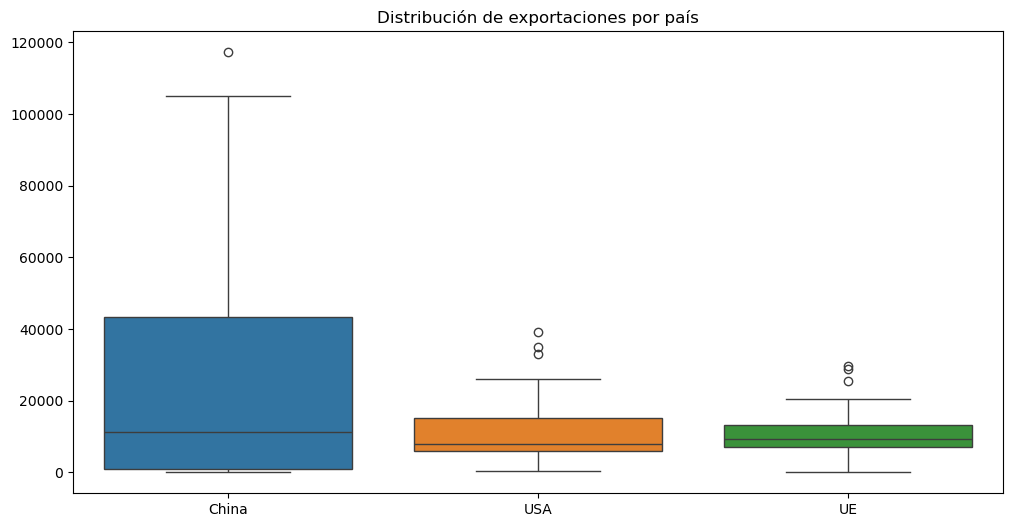

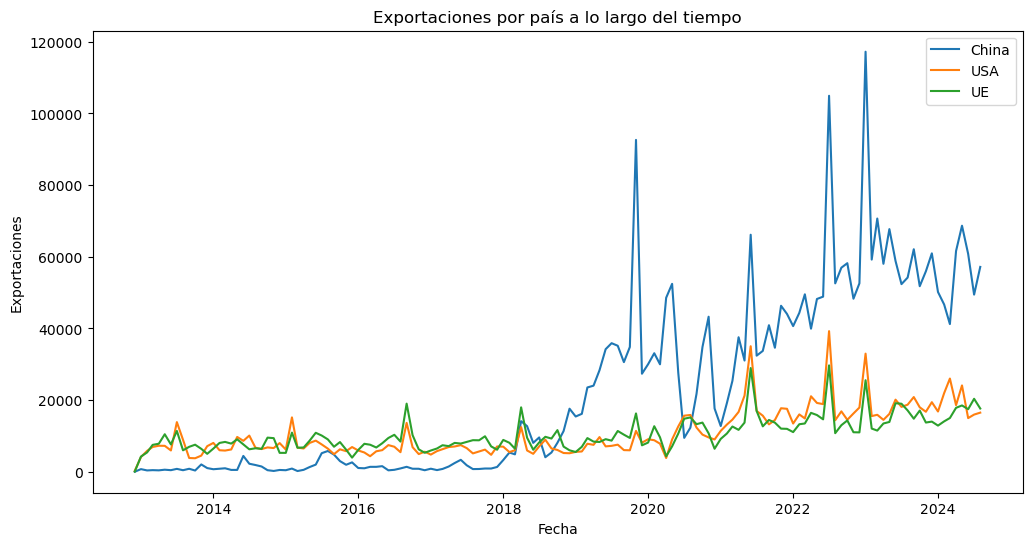

In [6]:
# Visualizar la distribución de los datos
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['China', 'USA', 'UE']])
plt.title('Distribución de exportaciones por país')
plt.show()

# Visualizar las series temporales
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['China'], label='China')
plt.plot(df['Date'], df['USA'], label='USA')
plt.plot(df['Date'], df['UE'], label='UE')
plt.xlabel('Fecha')
plt.ylabel('Exportaciones')
plt.title('Exportaciones por país a lo largo del tiempo')
plt.legend()
plt.show()

Agregar comentarios de el analisis

### Preprocesamiento del Dataset
aqui hay que hacer hasta dividir los 3 datasets por pais listos para que se puedan modelar en cualquiera de lso 3 modelos. Para ciertos modelos peude haber mas preprocesamiento eso es cuestion de cada uno.

In [3]:
# Dividir el dataframe por país y establecer la columna 'Date' como índice
df_china = df[['Date', 'China']].set_index('Date')
df_usa = df[['Date', 'USA']].set_index('Date')
df_ue = df[['Date', 'UE']].set_index('Date')

# Mostrar las primeras filas de cada dataframe
print("Datos de China:")
print(df_china.head())

print("\nDatos de USA:")
print(df_usa.head())

print("\nDatos de UE:")
print(df_ue.head())

Datos de China:
            China
Date             
2012-12-01     19
2013-01-01    740
2013-02-01    380
2013-03-01    459
2013-04-01    403

Datos de USA:
             USA
Date            
2012-12-01   291
2013-01-01  4119
2013-02-01  5844
2013-03-01  6929
2013-04-01  7266

Datos de UE:
              UE
Date            
2012-12-01    75
2013-01-01  4241
2013-02-01  5407
2013-03-01  7510
2013-04-01  7830


### Prueba Chat

In [8]:
# Convertir índice a datetime
df_china.index = pd.to_datetime(df_china.index, format='%d/%m/%Y')
# Asegurar frecuencia mensual
df_china = df_china.asfreq('MS')  # MS = Start of Month

# Repetir con df_usa y df_ue si fuera necesario
df_usa.index = pd.to_datetime(df_usa.index, format='%d/%m/%Y')
df_usa = df_usa.asfreq('MS')

df_ue.index = pd.to_datetime(df_ue.index, format='%d/%m/%Y')
df_ue = df_ue.asfreq('MS')


In [4]:
# Definimos el tamaño del test, por ejemplo, 12 observaciones (12 meses)
n_test = 12

# 4.1. Para CHINA
train_china = df_china.iloc[:-n_test].copy()
test_china  = df_china.iloc[-n_test:].copy()

print("CHINA:")
print("Tamaño de entrenamiento:", train_china.shape)
print("Tamaño de prueba:", test_china.shape)
print("Fechas de entrenamiento:", train_china.index.min(), " a ", train_china.index.max())
print("Fechas de prueba:", test_china.index.min(), " a ", test_china.index.max())
print("-------------------------------------------------------\n")

# 4.2. Para USA
train_usa = df_usa.iloc[:-n_test].copy()
test_usa  = df_usa.iloc[-n_test:].copy()

print("USA:")
print("Tamaño de entrenamiento:", train_usa.shape)
print("Tamaño de prueba:", test_usa.shape)
print("Fechas de entrenamiento:", train_usa.index.min(), " a ", train_usa.index.max())
print("Fechas de prueba:", test_usa.index.min(), " a ", test_usa.index.max())
print("-------------------------------------------------------\n")

# 4.3. Para UE
train_ue = df_ue.iloc[:-n_test].copy()
test_ue  = df_ue.iloc[-n_test:].copy()

print("UE:")
print("Tamaño de entrenamiento:", train_ue.shape)
print("Tamaño de prueba:", test_ue.shape)
print("Fechas de entrenamiento:", train_ue.index.min(), " a ", train_ue.index.max())
print("Fechas de prueba:", test_ue.index.min(), " a ", test_ue.index.max())




CHINA:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00
-------------------------------------------------------

USA:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00
-------------------------------------------------------

UE:
Tamaño de entrenamiento: (129, 1)
Tamaño de prueba: (12, 1)
Fechas de entrenamiento: 2012-12-01 00:00:00  a  2023-08-01 00:00:00
Fechas de prueba: 2023-09-01 00:00:00  a  2024-08-01 00:00:00


In [5]:
stepwise_model_china = auto_arima(
    train_china, 
    start_p=0, start_q=0,   # podemos empezar en 0 o 1
    max_p=3, max_q=3,       # para no irnos demasiado lejos en la búsqueda
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12,                   # estacionalidad (12 meses)
    seasonal=True,
    d=None,                 # auto_arima intentará detectar d
    D=None,                 # auto_arima intentará detectar D
    trace=True,             # para ver las iteraciones
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("CHINA - Mejor orden ARIMA encontrado (p,d,q):", stepwise_model_china.order)
print("CHINA - Mejor orden estacional (P,D,Q,m):", stepwise_model_china.seasonal_order)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2822.992, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2797.112, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2772.625, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2821.102, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2770.681, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2775.206, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2774.375, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2775.430, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2784.083, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2795.165, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2774.458, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=2771.481, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[12] intercept
Total fit time: 0.938 seconds
CHINA - Mejor orden ARIMA encontrado (p,d,q): (0, 1, 1)
CHINA - Mejor orden

In [6]:
# Extraemos los parámetros del auto_arima
order_china = stepwise_model_china.order
seasonal_order_china = stepwise_model_china.seasonal_order

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ajustar modelo SARIMAX con los parámetros de auto_arima
sarimax_china = SARIMAX(train_china,
                        order=order_china,
                        seasonal_order=seasonal_order_china,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results_china = sarimax_china.fit()

# Realizamos la predicción en el set de prueba
start_test_china = test_china.index[0]
end_test_china   = test_china.index[-1]
forecast_china   = results_china.predict(start=start_test_china, 
                                         end=end_test_china)



c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [7]:
stepwise_model_usa = auto_arima(
    train_usa, 
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12, 
    seasonal=True,
    d=None,
    D=None,
    trace=True, 
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("USA - Mejor orden ARIMA:", stepwise_model_usa.order)
print("USA - Mejor orden estacional:", stepwise_model_usa.seasonal_order)

# Predicción directa con pmdarima (opcional)
#n_periods_usa = len(test_usa)
#forecast_usa = stepwise_model_usa.predict(n_periods=n_periods_usa)
#forecast_usa = pd.Series(forecast_usa, index=test_usa.index)

# O convertir a SARIMAX (opcional)
order_usa = stepwise_model_usa.order
seasonal_order_usa = stepwise_model_usa.seasonal_order
sarimax_usa = SARIMAX(train_usa,
                      order=order_usa,
                      seasonal_order=seasonal_order_usa,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
results_usa = sarimax_usa.fit()
forecast_usa = results_usa.predict(start=test_usa.index[0], 
                                           end=test_usa.index[-1])



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2537.952, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2517.702, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2496.021, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2536.071, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2493.183, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2495.078, Time=0.23 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2498.219, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2493.257, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=2492.359, Time=0.09 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2494.318, Time=0.21 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=2494.325, Time=0.25 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=2496.046, Time=0.38 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=2493.961, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[12] intercept   : AIC=2493.832, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0

c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [8]:
stepwise_model_ue = auto_arima(
    train_ue, 
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    m=12, 
    seasonal=True,
    d=None,
    D=None,
    trace=True, 
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("UE - Mejor orden ARIMA:", stepwise_model_ue.order)
print("UE - Mejor orden estacional:", stepwise_model_ue.seasonal_order)

# Predicción directa con pmdarima
#n_periods_ue = len(test_ue)
#forecast_ue = stepwise_model_ue.predict(n_periods=n_periods_ue)
#forecast_ue = pd.Series(forecast_ue, index=test_ue.index)

# O convertir a SARIMAX
order_ue = stepwise_model_ue.order
seasonal_order_ue = stepwise_model_ue.seasonal_order
sarimax_ue = SARIMAX(train_ue,
                     order=order_ue,
                     seasonal_order=seasonal_order_ue,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
results_ue = sarimax_ue.fit()
forecast_ue = results_ue.predict(start=test_ue.index[0], 
                                         end=test_ue.index[-1])


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2512.589, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2494.787, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2459.011, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2510.713, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2460.918, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2460.926, Time=0.58 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2460.021, Time=0.99 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2458.403, Time=0.35 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2460.032, Time=1.03 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2514.451, Time=0.04 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2461.308, Time=0.28 sec
 ARIMA(0,1,2)(1,0,0)[12] intercept   : AIC=2458.528, Time=0.41 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2460.128, Time=0.46 sec
 ARIMA(0,1,1)(1,0,0)[12]

c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [9]:
# ---------------------
# 3.1. METRICS FOR CHINA
# ---------------------
mae_china = mean_absolute_error(test_china, forecast_china)
mse_china = mean_squared_error(test_china, forecast_china)
rmse_china = np.sqrt(mse_china)
mape_china = mean_absolute_percentage_error(test_china, forecast_china) * 100

print("==== CHINA METRICS ====")
print(f"MAE:  {mae_china:.2f}")
print(f"RMSE: {rmse_china:.2f}")
print(f"MAPE: {mape_china:.2f}%\n")

# -------------------
# 3.2. METRICS FOR USA
# -------------------
mae_usa = mean_absolute_error(test_usa, forecast_usa)
mse_usa = mean_squared_error(test_usa, forecast_usa)
rmse_usa = np.sqrt(mse_usa)
mape_usa = mean_absolute_percentage_error(test_usa, forecast_usa) * 100

print("==== USA METRICS ====")
print(f"MAE:  {mae_usa:.2f}")
print(f"RMSE: {rmse_usa:.2f}")
print(f"MAPE: {mape_usa:.2f}%\n")

# -----------------
# 3.3. METRICS FOR UE
# -----------------
mae_ue = mean_absolute_error(test_ue, forecast_ue)
mse_ue = mean_squared_error(test_ue, forecast_ue)
rmse_ue = np.sqrt(mse_ue)
mape_ue = mean_absolute_percentage_error(test_ue, forecast_ue) * 100

print("==== UE METRICS ====")
print(f"MAE:  {mae_ue:.2f}")
print(f"RMSE: {rmse_ue:.2f}")
print(f"MAPE: {mape_ue:.2f}%")


==== CHINA METRICS ====
MAE:  6660.54
RMSE: 8304.04
MAPE: 13.26%

==== USA METRICS ====
MAE:  2655.09
RMSE: 3378.09
MAPE: 13.15%

==== UE METRICS ====
MAE:  1850.40
RMSE: 2349.37
MAPE: 11.36%


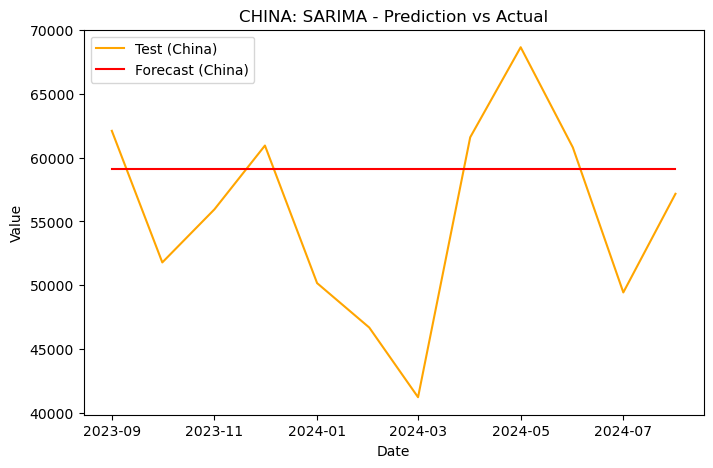

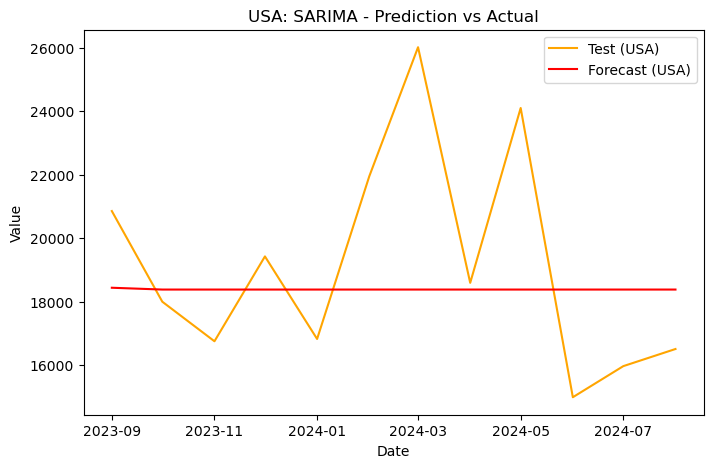

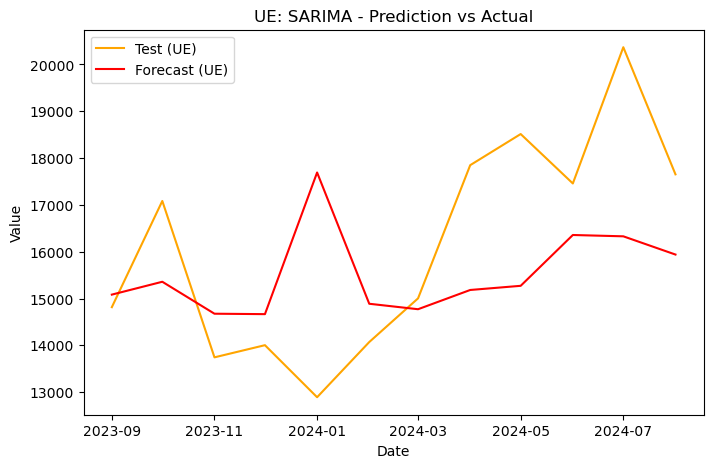

In [13]:
# 4.1 Plot for CHINA
plt.figure(figsize=(8, 5))
#plt.plot(train_china.index, train_china, label='Train (China)')
plt.plot(test_china.index, test_china, label='Test (China)', color='orange')
plt.plot(forecast_china.index, forecast_china, label='Forecast (China)', color='red')
plt.title('CHINA: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


# 4.2 Plot for USA
plt.figure(figsize=(8, 5))
#plt.plot(train_usa.index, train_usa, label='Train (USA)')
plt.plot(test_usa.index, test_usa, label='Test (USA)', color='orange')
plt.plot(forecast_usa.index, forecast_usa, label='Forecast (USA)', color='red')
plt.title('USA: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


# 4.3 Plot for UE
plt.figure(figsize=(8, 5))
#plt.plot(train_ue.index, train_ue, label='Train (UE)')
plt.plot(test_ue.index, test_ue, label='Test (UE)', color='orange')
plt.plot(forecast_ue.index, forecast_ue, label='Forecast (UE)', color='red')
plt.title('UE: SARIMA - Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


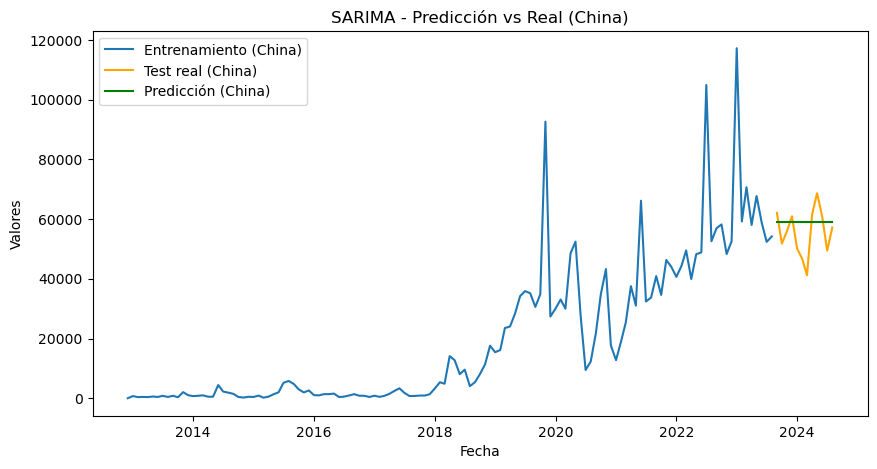

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(train_china, label='Entrenamiento (China)')
plt.plot(test_china, label='Test real (China)', color='orange')
plt.plot(forecast_china, label='Predicción (China)', color='green')
plt.title('SARIMA - Predicción vs Real (China)')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.show()


### División del Dataset en Datos de Entrenamiento y Datos de Testeo

In [7]:
#dividir en entrenamiento
#dividir en test
# prueba dos

### Modelado de datos

In [8]:
###prueba 3 jose xavier


### Evaluación de Modelo

### Fine-Tuning de Modelo

In [13]:
from sklearn.model_selection import GridSearchCV

# Configuración de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Función para hacer GridSearchCV y entrenar
def fine_tune_model(X_train, y_train):
    model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_absolute_error',
        verbose=2,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_

# Ajustar para cada región
best_model_china, best_params_china = fine_tune_model(X_train_china, y_train_china)
best_model_usa, best_params_usa = fine_tune_model(X_train_usa, y_train_usa)
best_model_ue, best_params_ue = fine_tune_model(X_train_ue, y_train_ue)

print("Mejores hiperparámetros para China:", best_params_china)
print("Mejores hiperparámetros para USA:", best_params_usa)
print("Mejores hiperparámetros para UE:", best_params_ue)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Fitting 3 folds for each of 144 candidates, totalling 432 fits
Mejores hiperparámetros para China: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Mejores hiperparámetros para USA: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Mejores hiperparámetros para UE: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### Evaluación Final de Modelo

In [14]:
# Evaluar el modelo ajustado
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    return mae, rmse, mape

mae_china_ft, rmse_china_ft, mape_china_ft = evaluate_model(best_model_china, X_test_china, y_test_china)
mae_usa_ft, rmse_usa_ft, mape_usa_ft = evaluate_model(best_model_usa, X_test_usa, y_test_usa)
mae_ue_ft, rmse_ue_ft, mape_ue_ft = evaluate_model(best_model_ue, X_test_ue, y_test_ue)

# Resultados finales
print("Resultados ajustados para China:")
print(f"MAE: {mae_china:.2f}, RMSE: {rmse_china:.2f}, MAPE: {mape_china:.2f}%")

print("\nResultados ajustados para USA:")
print(f"MAE: {mae_usa:.2f}, RMSE: {rmse_usa:.2f}, MAPE: {mape_usa:.2f}%")

print("\nResultados ajustados para UE:")
print(f"MAE: {mae_ue:.2f}, RMSE: {rmse_ue:.2f}, MAPE: {mape_ue:.2f}%")


Resultados ajustados para China:
MAE: 18276.20, RMSE: 24135.12, MAPE: 26.82%

Resultados ajustados para USA:
MAE: 4207.72, RMSE: 6427.25, MAPE: 19.77%

Resultados ajustados para UE:
MAE: 3171.52, RMSE: 4732.29, MAPE: 18.24%


c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\timeseries_env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


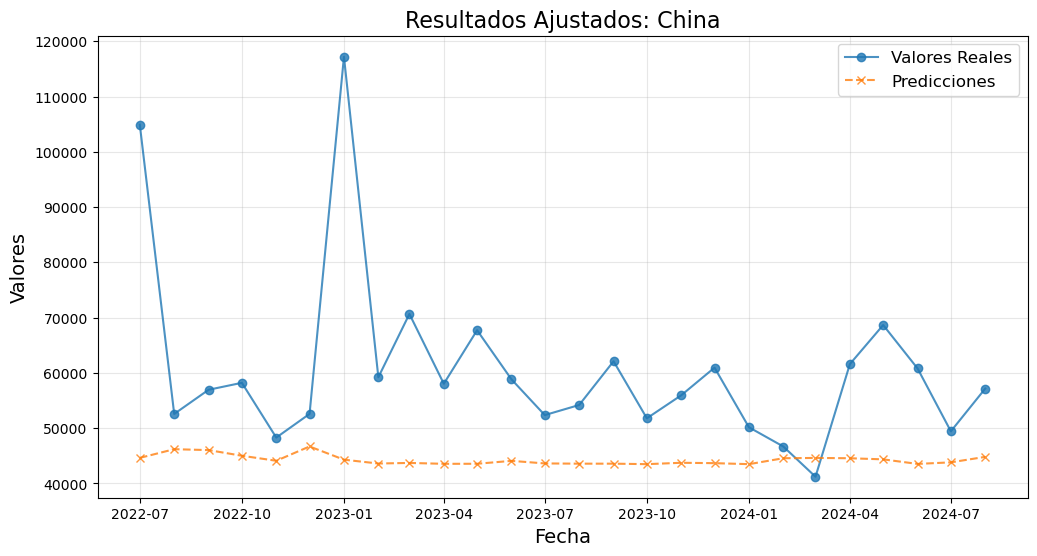

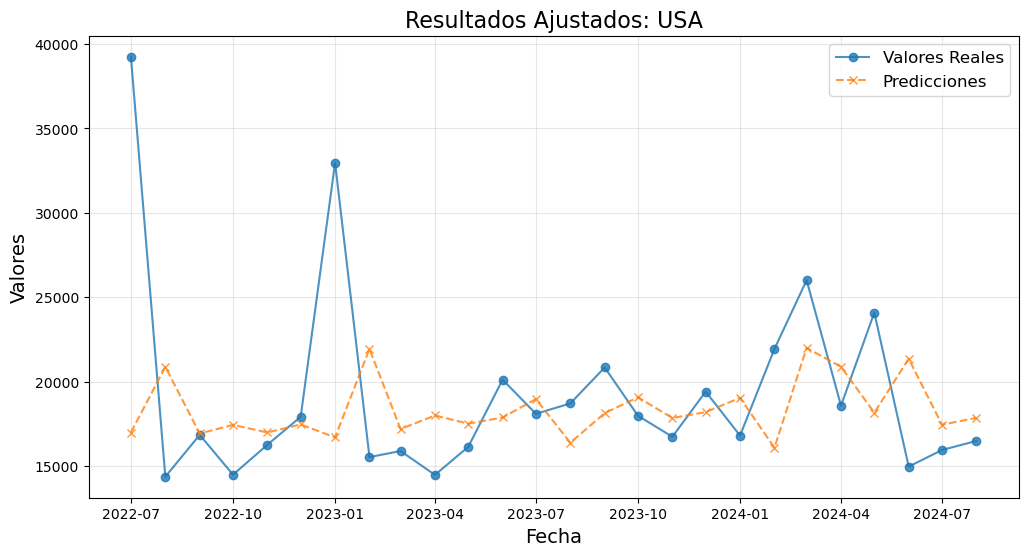

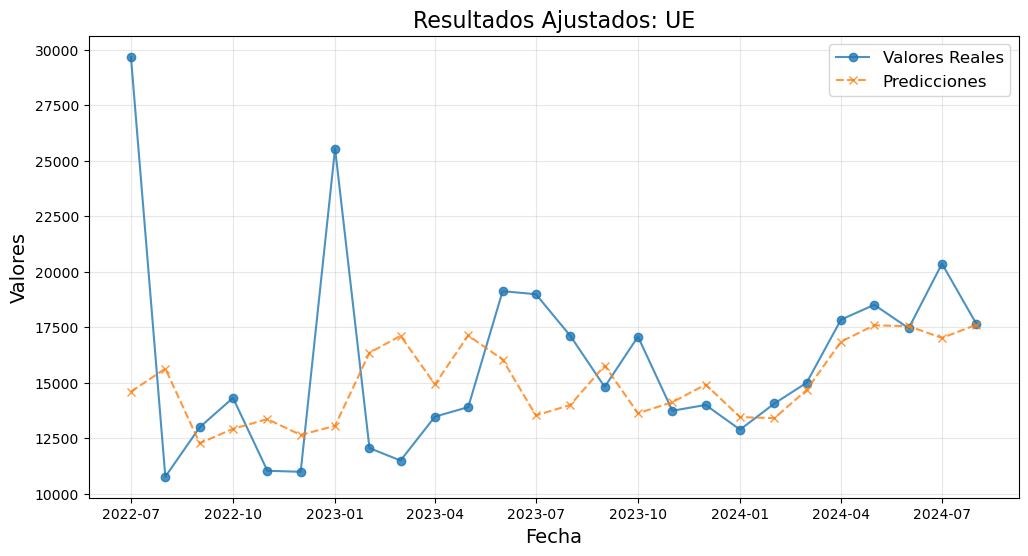

In [15]:
# Función para graficar resultados
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test, label='Valores Reales', marker='o', linestyle='-', alpha=0.8)
    plt.plot(y_test.index, predictions, label='Predicciones', marker='x', linestyle='--', alpha=0.8)
    plt.title(title, fontsize=16)
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Valores', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Generar predicciones ajustadas para cada región
predictions_china = best_model_china.predict(X_test_china)
predictions_usa = best_model_usa.predict(X_test_usa)
predictions_ue = best_model_ue.predict(X_test_ue)

# Graficar resultados para cada región
plot_predictions(y_test_china, predictions_china, "Resultados Ajustados: China")
plot_predictions(y_test_usa, predictions_usa, "Resultados Ajustados: USA")
plot_predictions(y_test_ue, predictions_ue, "Resultados Ajustados: UE")


### Comparación Modelos RM sin y con Fine-Tuning

In [16]:
# Resultados antes del ajuste
original_results = {
    'Región': ['China', 'USA', 'UE'],
    'MAE Original': [mae_china, mae_usa, mae_ue],
    'RMSE Original': [rmse_china, rmse_usa, rmse_ue],
    'MAPE Original': [mape_china, mape_usa, mape_ue]
}

# Resultados después del ajuste
fine_tuned_results = {
    'Región': ['China', 'USA', 'UE'],
    'MAE Fine-Tuned': [mae_china_ft, mae_usa_ft, mae_ue_ft],
    'RMSE Fine-Tuned': [rmse_china_ft, rmse_usa_ft, rmse_ue_ft],
    'MAPE Fine-Tuned': [mape_china_ft, mape_usa_ft, mape_ue_ft]
}

# Combinar los resultados en un DataFrame
comparison_df = pd.DataFrame(original_results).merge(pd.DataFrame(fine_tuned_results), on='Región')



In [17]:
comparison_df

,Región,MAE Original,RMSE Original,MAPE Original,MAE Fine-Tuned,RMSE Fine-Tuned,MAPE Fine-Tuned
0,China,18276.200385,24135.118113,26.818027,16702.007132,23034.180286,24.103198
1,USA,4207.721154,6427.253640,19.770865,3958.897179,6295.970349,18.231375
2,UE,3171.520385,4732.285177,18.235893,2979.669197,4630.261671,17.422668


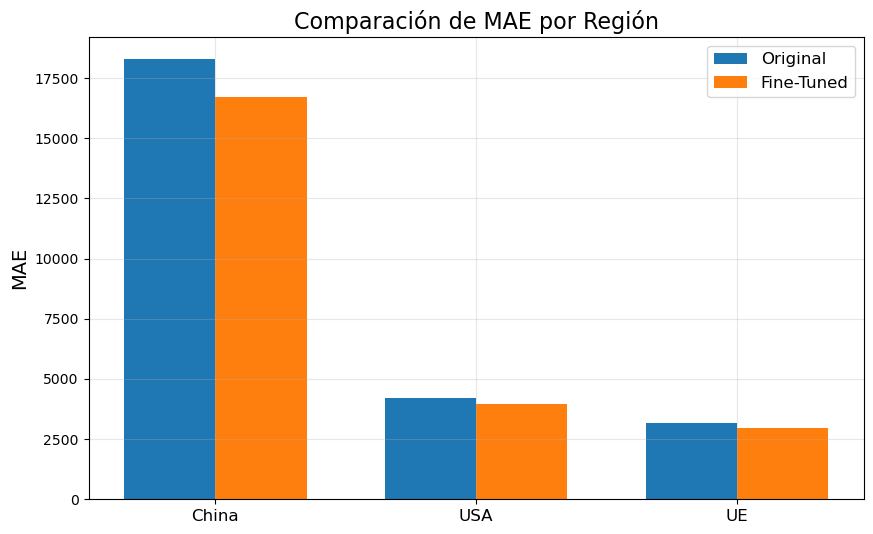

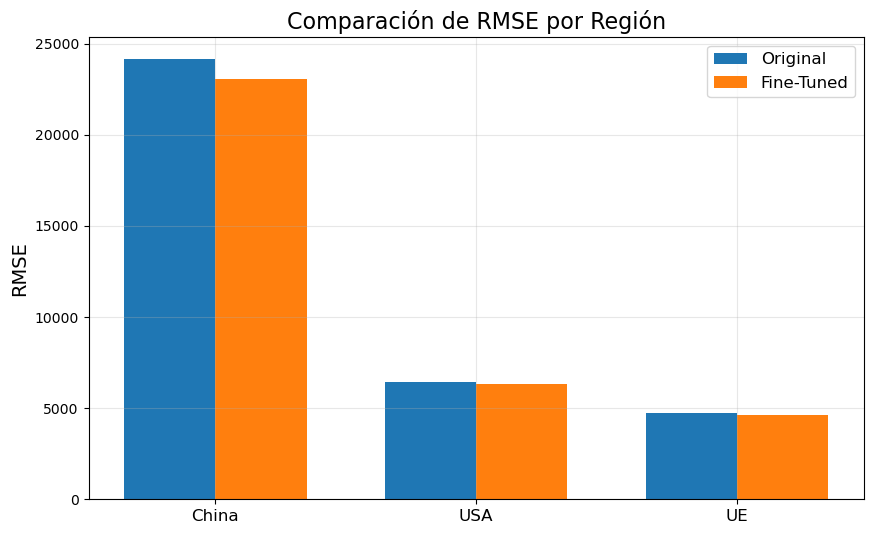

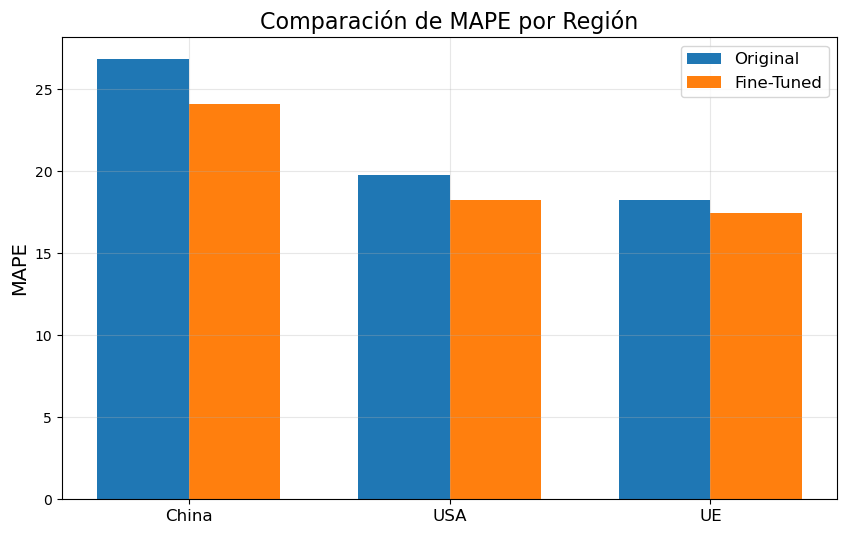

In [18]:
# Configurar datos para graficar
regions = comparison_df['Región']
metrics = ['MAE', 'RMSE', 'MAPE']
width = 0.35  # Ancho de las barras

# Iterar por cada métrica y graficar
for metric in metrics:
    original_metric = comparison_df[f'{metric} Original']
    fine_tuned_metric = comparison_df[f'{metric} Fine-Tuned']
    
    x = np.arange(len(regions))
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, original_metric, width, label='Original')
    plt.bar(x + width / 2, fine_tuned_metric, width, label='Fine-Tuned')
    
    plt.title(f'Comparación de {metric} por Región', fontsize=16)
    plt.xticks(x, regions, fontsize=12)
    plt.ylabel(metric, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()


analisis y comentarios

### Comparación del Desempeño de Modelos

In [9]:
# 9 comparaciones 
# 3 paises y 3 modelos